In [114]:
from pathlib import Path
from datetime import datetime, timedelta
from functools import reduce
from operator import add

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.dates as mdates

from music_league_graphs.scraper import create_dataframe
from music_league_graphs.spotify_api import SpotifyAPI

In [115]:
df, names = create_dataframe(Path("../league_rounds/"))

df["round_score"] = df[names].sum(axis=1)
df["round_rank"] = df.groupby("round")["round_score"].rank(ascending=False).astype(int)


If you want to convert the music league user names to real names create a translator dictionary like the one below. Otherwise set translator to `None`, or just delete the block below

In [116]:

translator = {
    "Sacha Darwin": "Sacha",
    "Bethany Dickens-Devereux": "Bethany",
    "sam24ahhhhhh": "Sam",
    "Martha Mukungurutse": "Martha",
    "Victoria Whitehead": "Victoria",
    "Andrej Zacharenkov": "Andrej",
    "fred": "Fred",
    "Jenny": "Jenny B",
    "Tim            :)": "Tim P",
    "Mel Shallcrass": "Mel",
    "Jamie England": "Jamie",
    "Helen Adams": "Helen",
    "Rory": "Rory",
    "murraypurves101": "Murray",
    "James Hardwick": "James",
    "Olek": "Olek",
    "Russell": "Russell",
    "owainst": "Owain",
    "Tim": "Tim C",
    "Figataur": "Mark",
    "Jenny Seaborne": "Jenny S",
    "diplodocus.17": "Harry",
    "Sowdagar": "Sow",
    "[Left the league]": "[Left the league]",
    "Peter Rowe": "Peter R",
}

if translator is not None:
        df = df.replace(translator)
        df = df.rename(mapper=translator, axis=1)
        names = list(set(translator.values()).intersection(set(df.keys())))

In [118]:
try:
    api = SpotifyAPI()
    api.get_data(df["song_id"])
    spotify_data = api.df
    df = pd.concat((df, spotify_data), axis=1)
except RuntimeError:
    print("Couldn't access spotify API")
    raise

/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Simply sorting the dataframe won't resolve ties correctly. The below one does

In [119]:
def resolve_podium(df) -> list[str]:
    """
    Resolve the winning order in case of draws in points. Resolution order is:
    1. Largest total positive votes
    2. Lowest number of down votes (not)
    """
    rankings = df.groupby("submitter")["round_score"].sum().rank(ascending=False).astype(int).sort_values()
    winning_order: list[str] = []

    rank = 1

    while rank != len(rankings) + 1:
        if len(rankings[rankings == rank]) > 1:
            tied_names = rankings[rankings == rank].index
            tie_break_df = df[df["submitter"].isin(tied_names)]
            tie_break_df.loc[:, names] = tie_break_df[names].map(lambda x: x if x > 0 else 0) # remove all downvotes
            positive_votes =  tie_break_df.groupby("submitter")[names].sum().sum(axis=1).sort_values()
            if len(set(positive_votes)) < len(positive_votes):
                print("Tie break unresolved, alphabetical order used")
            order = [k for k, _ in sorted(positive_votes.to_dict().items(), key=lambda item: item[1], reverse=True)]
            winning_order += order
            rank += len(order)
        else:
            winning_order.append((rankings[rankings==rank]).index[0])
            rank += 1
        if len(winning_order) == len(rankings):
            break
    return winning_order

winning_order = resolve_podium(df)


## Round Winners

Below we list all of the winners for each round

In [120]:
for round_name, scores in df.groupby("round"):
    winning_score = scores["round_score"].max()
    a = f"Round     | {round_name}"
    print(a + "\n" + '-'*len(a))
    for _, row in scores[scores["round_score"] == winning_score][["submitter", "song_name", "round_score"]].iterrows():
        print(f"{row['submitter']:10} | {row['song_name']:40} | {int(row['round_score'])}")
    print()


Round     | Best live version 🎤
-------------------------------
Jenny S    | The Man Who Sold The World - Live        | 24

Round     | Best sample 🎛
-------------------------
Jamie      | Stan                                     | 16

Round     | Best solo breakout from group 🚀
-------------------------------------------
Helen      | Edge of Seventeen                        | 18

Round     | Best summer song ☀
------------------------------
Martha     | Mas Que Nada                             | 20

Round     | Boxing entrance music 🥊
-----------------------------------
Martha     | X Gon' Give It To Ya                     | 20

Round     | Obscurity 🕵️‍♀️
---------------------------
Harry      | We Need Jungle I'm Afraid                | 15

Round     | One hit wonder 🌟
----------------------------
Jenny S    | Teenage Dirtbag                          | 15
Owain      | Somebody That I Used To Know             | 15

Round     | Riskware's anthem 🎶
-------------------------------
Mark 

### Highest and lowest scores across the league's rounds

In [121]:
# highest
df.sort_values("round_score", ascending=False).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
0,Best live version 🎤,Jenny S,The Man Who Sold The World - Live,24.0
61,Best summer song ☀,Martha,Mas Que Nada,20.0
81,Boxing entrance music 🥊,Martha,X Gon' Give It To Ya,20.0
142,Riskware's anthem 🎶,Mark,We Care a Lot,19.0
2,Best live version 🎤,Bethany,Lapdance (Live),19.0
184,To the polls❌,Martha,Zombie,19.0
163,Song with a drink in the title 🍸,Helen,Black Coffee,18.0
40,Best solo breakout from group 🚀,Helen,Edge of Seventeen,18.0
20,Best sample 🎛,Jamie,Stan,16.0
42,Best solo breakout from group 🚀,Harry,In The Air Tonight - 2015 Remastered,15.0


In [122]:
# lowest
df.sort_values("round_score", ascending=True).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
19,Best live version 🎤,Olek,Final - Live Version - Rappel,-12.0
162,Riskware's anthem 🎶,Fred,Funny Little Man,-11.0
204,To the polls❌,Sam,Do They Know It's Christmas? - 1984 Version,-11.0
60,Best solo breakout from group 🚀,Tim C,Paranoid (2012 Remaster),-9.0
183,Song with a drink in the title 🍸,Mark,Tubthumping,-8.0
121,Obscurity 🕵️‍♀️,Olek,Phobia - Live,-6.0
59,Best solo breakout from group 🚀,Sam,Wonderful Christmastime - Full Length Version ...,-6.0
18,Best live version 🎤,Sacha,Shades of Grey - Live,-6.0
141,One hit wonder 🌟,Olek,Love Is All I Got,-6.0
203,To the polls❌,Olek,Woman,-5.0


## Voting Matrix

The voting matrix shows the cumlative votes given between every player across all of the rounds.

In [123]:
# arr has shape (num_rounds, num_competitors, num_competitors)
# Any missing values are filled with 0.0

arr: list[np.ndarray] = []
for _, a in df.set_index("submitter").groupby("round")[winning_order]:
    a = a.reindex(winning_order).fillna(0).to_numpy()
    arr.append(a[None, :, :])

arr = np.concat(arr)
voting_matrix = np.sum(arr, axis=0)

Rows are the points received, columns the points given. The rows and columns are sorted into the final order of the league

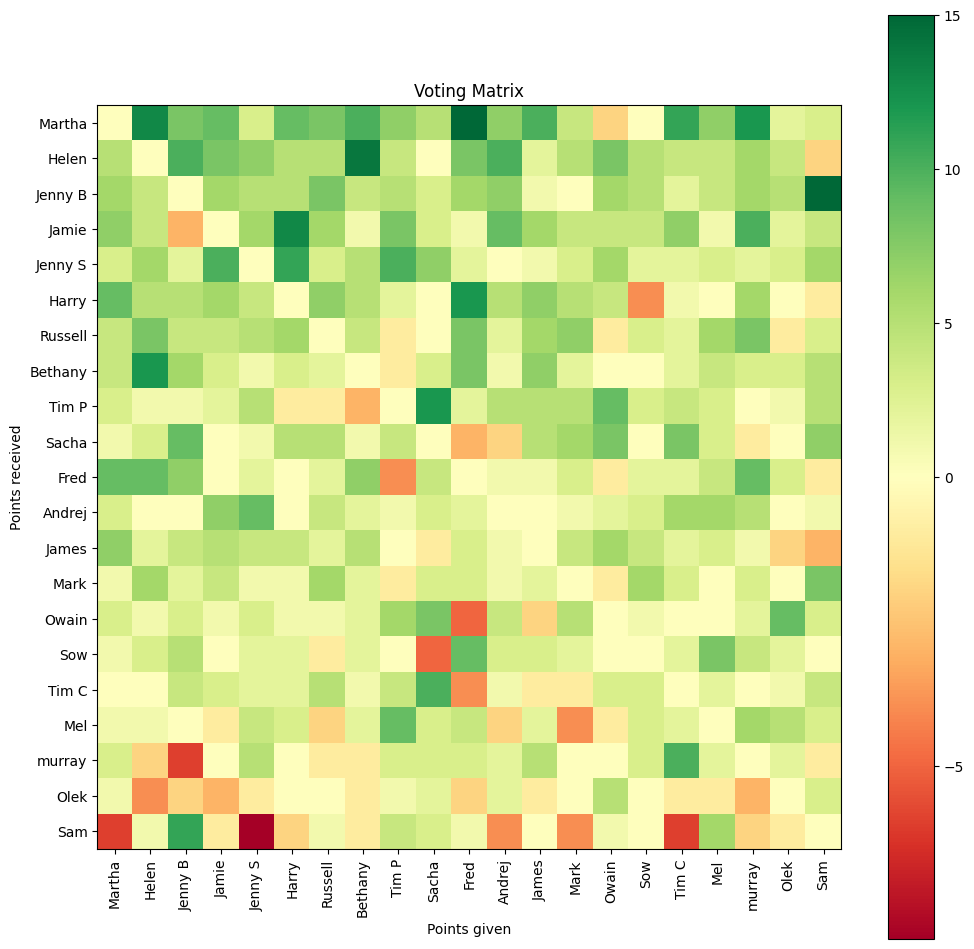

In [124]:
fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.xlabel("Points given")
plt.ylabel("Points received")
plt.title("Voting Matrix")


cbar = plt.colorbar()

plt.show()

In [125]:
# Biggest differences 

reciprocals = np.abs((np.triu(voting_matrix) - np.tril(voting_matrix).T))
diffs = np.unravel_index(np.argsort(reciprocals.reshape(-1))[::-1][:10], reciprocals.shape)

for row, col in zip(*diffs):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Sam for Jenny S: 6
murray for Jenny B: 6
Fred for Harry: 12
Sam for Mark: 8
Tim C for Martha: 11
Andrej for Helen: 10
murray for Tim C: 0
murray for Jamie: 10
Sam for Tim C: 4
murray for Russell: 8


### Biggest Stans and biggest haters

In [126]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[::-1][:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Fred for Martha: 15
Sam for Jenny B: 15
Bethany for Helen: 14
Helen for Martha: 13
Harry for Jamie: 13
murray for Martha: 12
Helen for Bethany: 12
Sacha for Tim P: 12
Fred for Harry: 12
Harry for Jenny S: 11


In [127]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Jenny S for Sam: -8
Tim C for Sam: -6
Martha for Sam: -6
Jenny B for murray: -6
Sacha for Sow: -5
Fred for Owain: -5
Mark for Mel: -4
Helen for Olek: -4
Sow for Harry: -4
Tim P for Fred: -4


## Voting Correlation

This shows who votes similarly, and who doesn't. Note that the matrix is symmetrical

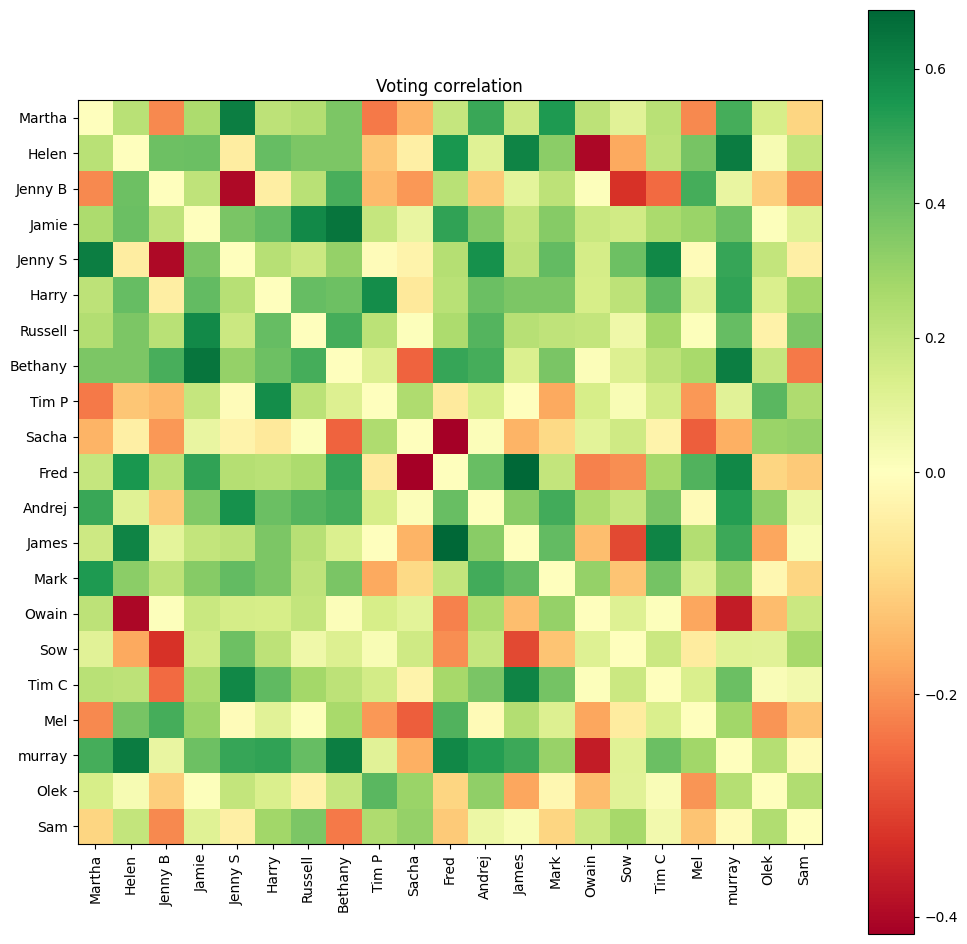

In [128]:
# Sort arr into an array that's lists of each competitors votes per round

voting_correlation = np.corrcoef(np.vstack(voting_matrix).T)
np.fill_diagonal(voting_correlation, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_correlation),
                        vcenter=0,
                        vmax=np.max(voting_correlation))

plt.imshow(voting_correlation, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Voting correlation")


cbar = plt.colorbar()

plt.show()

### Most and least voting-correlated

In [129]:
most_correlated = np.unravel_index(np.argsort(-voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

Fred and James: 0.69
Jamie and Bethany: 0.65
Helen and murray: 0.63
Jenny S and Martha: 0.62
murray and Bethany: 0.62
James and Helen: 0.60
James and Tim C: 0.60
Tim C and Jenny S: 0.59
murray and Fred: 0.59
Jamie and Russell: 0.59


In [130]:
least_correlated = np.unravel_index(np.argsort(voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

Sacha and Fred: -0.42
Owain and Helen: -0.40
Jenny S and Jenny B: -0.40
murray and Owain: -0.36
Jenny B and Sow: -0.33
Sow and James: -0.30
Mel and Sacha: -0.27
Sacha and Bethany: -0.26
Jenny B and Tim C: -0.25
Martha and Tim P: -0.23


## Genre Correlation

See who submitted similar genres. Note that Spotify's list of genres is pretty wild, so this is pretty rough

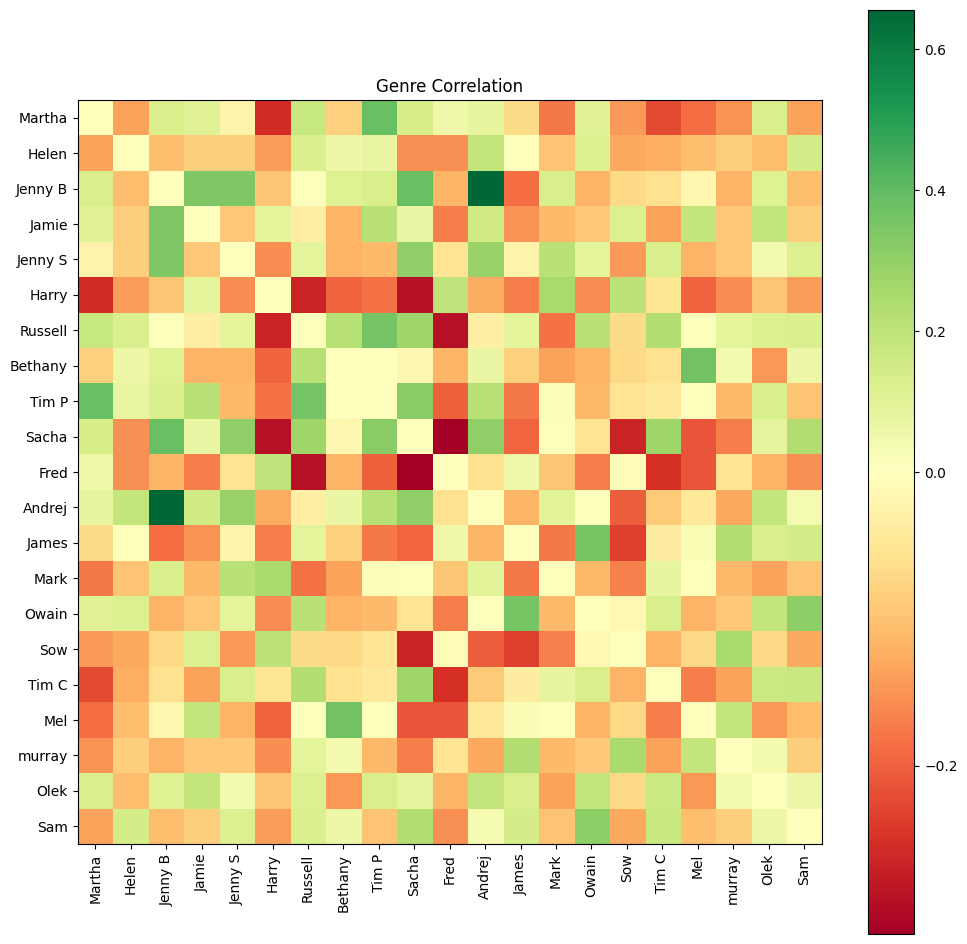

In [131]:
unique_genres = set()

for submitter in winning_order:
    rest = set(reduce(add, df[df.submitter != submitter]["genres"].values))
    unique_genres |= set(reduce(add, df[df.submitter == submitter]["genres"])).difference(rest)

all_genres = list({genre for genres in df.genres for genre in genres}.difference(unique_genres))

x = df.groupby("submitter")["genres"].apply(lambda x: reduce(add, x)).reindex(winning_order).map(set)

genre_matrix = np.zeros((len(winning_order), len(all_genres)))

for i, genres in enumerate(x.values):
    for j, genre in enumerate(all_genres):
        if genre in genres:
            genre_matrix[i][j] = 1.0

voting_matrix = np.corrcoef(genre_matrix)
np.fill_diagonal(voting_matrix, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Genre Correlation")


cbar = plt.colorbar()

plt.show()

### Most and least genre correlated

In [132]:
most_genre_correlated = np.unravel_index(np.argsort(-voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Andrej and Jenny B: 0.66
Tim P and Martha: 0.38
Sacha and Jenny B: 0.38
Bethany and Mel: 0.36
Tim P and Russell: 0.36
James and Owain: 0.36
Jamie and Jenny B: 0.34
Jenny B and Jenny S: 0.34
Tim P and Sacha: 0.32
Owain and Sam: 0.31


In [133]:
least_genre_correlated = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Sacha and Fred: -0.31
Fred and Russell: -0.29
Harry and Sacha: -0.29
Harry and Russell: -0.27
Sacha and Sow: -0.27
Harry and Martha: -0.26
Fred and Tim C: -0.25
Sow and James: -0.23
Martha and Tim C: -0.22
Sacha and Mel: -0.21


## Average positive vote given out

Look at who chunks their votes into lumps vs those who scatter their votes like chicken feed

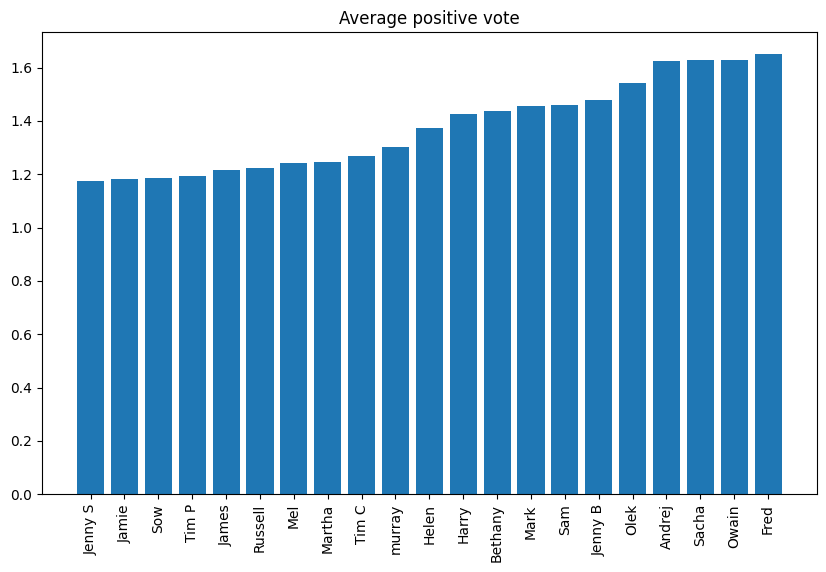

In [134]:
x = arr.reshape(-1, len(winning_order))
x[x <= 0.0] = np.nan
a = np.nanmean(x, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Average positive vote")

ax.bar(np.arange(len(winning_order)), a[np.argsort(a)])
ax.set_xticks(np.arange(len(winning_order)), labels=[winning_order[i] for i in np.argsort(a)], rotation="vertical")

plt.show()

## Average song age

Plot every players average song age with respect to today (or when this notebook was run). Note that the accuracy of date on some songs is worse than others (year vs month vs day, so this isn't 100% accurate)

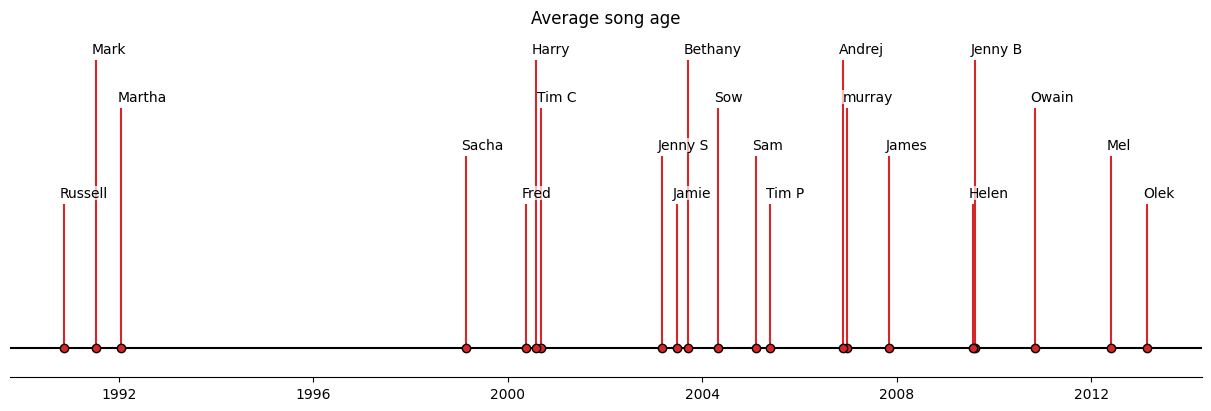

In [135]:
df["song_age_seconds"] = (datetime.now() - df["release_date"]).dt.total_seconds()
ages = df.groupby("submitter")["song_age_seconds"].mean().sort_values().map(lambda x: datetime.now() - timedelta(seconds=x))

fig, ax = plt.subplots(figsize=(12, 4), layout="constrained")
ax.set(title="Average song age")

levels = [(i % 4) / 3 + 1 for i in range(len(ages))]

# The vertical stems.
ax.vlines(ages, 0, levels,
          color=[("tab:red", 1)
                 for _ in ages])
# The baseline.
ax.axhline(0, c="black")
# The markers on the baseline
ax.plot(ages, np.zeros_like(ages), "ko", mfc="tab:red")

# Annotate the lines.
for date, level, name in zip(ages, levels, ages.index):
    ax.annotate(name, xy=(date, level),
                xytext=(-3, np.sign(level)*3), textcoords="offset points",
                verticalalignment="bottom" if level > 0 else "top",
                bbox=dict(boxstyle='square', pad=0, lw=0, fc=(1, 1, 1, 0.7)))

ax.yaxis.set(major_locator=mdates.YearLocator(),
             major_formatter=mdates.DateFormatter("%Y"))

# Remove the y-axis and some spines.
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

In [136]:
oldest = df.groupby("submitter")["song_age_seconds"].max().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()
youngest = df.groupby("submitter")["song_age_seconds"].min().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()

oldest_oldest = df.iloc[df[df["submitter"] == oldest.index[0]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_oldest = df.iloc[df[df["submitter"] == oldest.index[-1]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_youngest = df.iloc[df[df["submitter"] == youngest.index[-1]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]
oldest_youngest = df.iloc[df[df["submitter"] == youngest.index[0]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]

print(oldest_youngest.to_list())


['Sacha', Timestamp('2008-02-08 00:00:00'), 'Thriller']


In [137]:
# does song age correlate with overall position

np.corrcoef(np.c_[ages.reindex(winning_order).argsort(), np.arange(len(ages))].T)

array([[1.        , 0.34025974],
       [0.34025974, 1.        ]])

### Mean song length

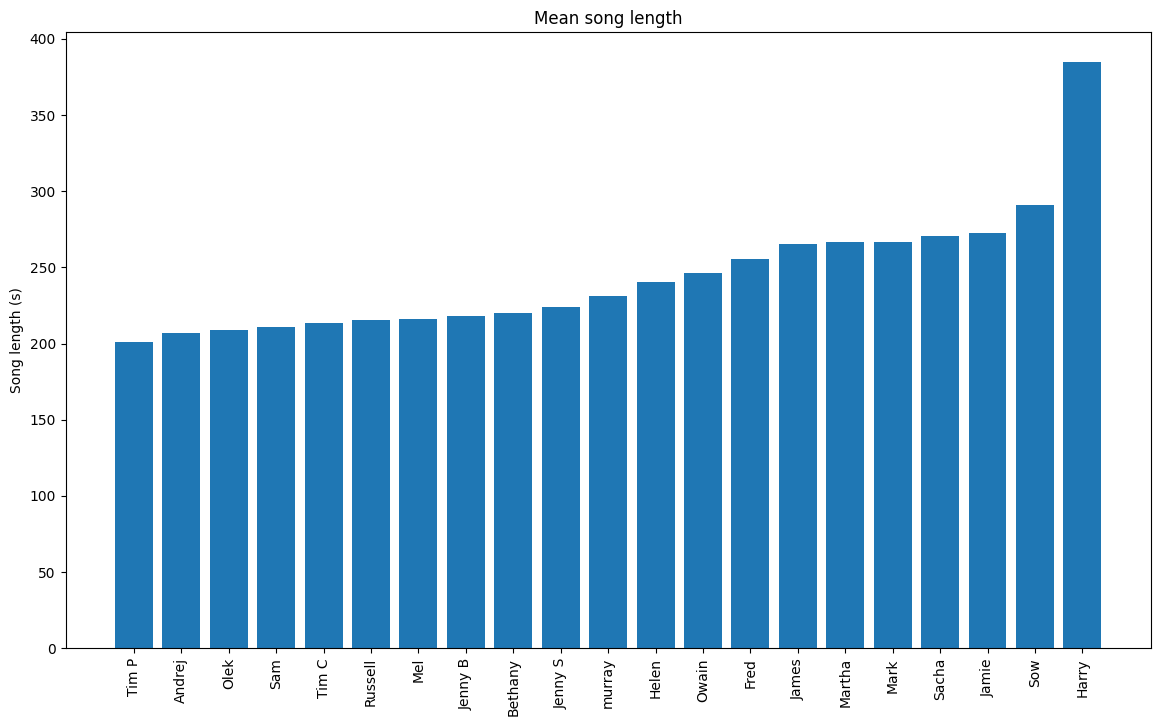

In [138]:
lengths = df.groupby("submitter")["duration_s"].mean().sort_values()

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(np.arange(len(lengths)), lengths)
ax.set_xticks(np.arange(len(winning_order)), lengths.index, rotation='vertical')
ax.set_title("Mean song length")
ax.set_ylabel("Song length (s)")
plt.show()

In [139]:
# Correlation between mean song length and overall league rank
np.corrcoef(lengths.reindex(winning_order).rank(), np.arange(1, len(winning_order)+1))


array([[ 1.       , -0.3012987],
       [-0.3012987,  1.       ]])

### Longest and shortest songs

In [140]:
df.sort_values("duration_s", ascending=False)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
14,Harry,"The Curtain - Live From Dordrecht, Het Energie...",909.106
191,Harry,Zombie,745.653
194,Mel,Hurricane,512.732
9,Sow,Recurring/We Could Forever - Live,479.573
117,Mark,"Given Up - Original 12"" Mix",464.000
157,Martha,Computer Love - 2009 Remaster,439.440
62,Harry,Hot Hot Hot,404.426
20,Jamie,Stan,404.106
137,James,Music Sounds Better With You,403.293
108,Sow,Sweetness Is My Weakness,390.413


In [141]:
df.sort_values("duration_s", ascending=True)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
93,Tim P,Theme from Strictly Come Dancing,42.000
119,Sam,Fire Alarm,85.395
192,Tim C,Tory Is A 4 Letter Word Pt II,100.586
145,Andrej,Cut Every Corner,109.275
148,Mel,Got The Autism,115.384
98,Bethany,Nervous Breakdown,129.173
186,Jenny B,We Live Here,131.876
178,Russell,Two Pints of Lager and a Packet of Crisps Please,133.360
174,Jenny S,Tequila,135.240
179,James,Champagne Shots,144.000


## Rankings if only downvotes/upvotes counted

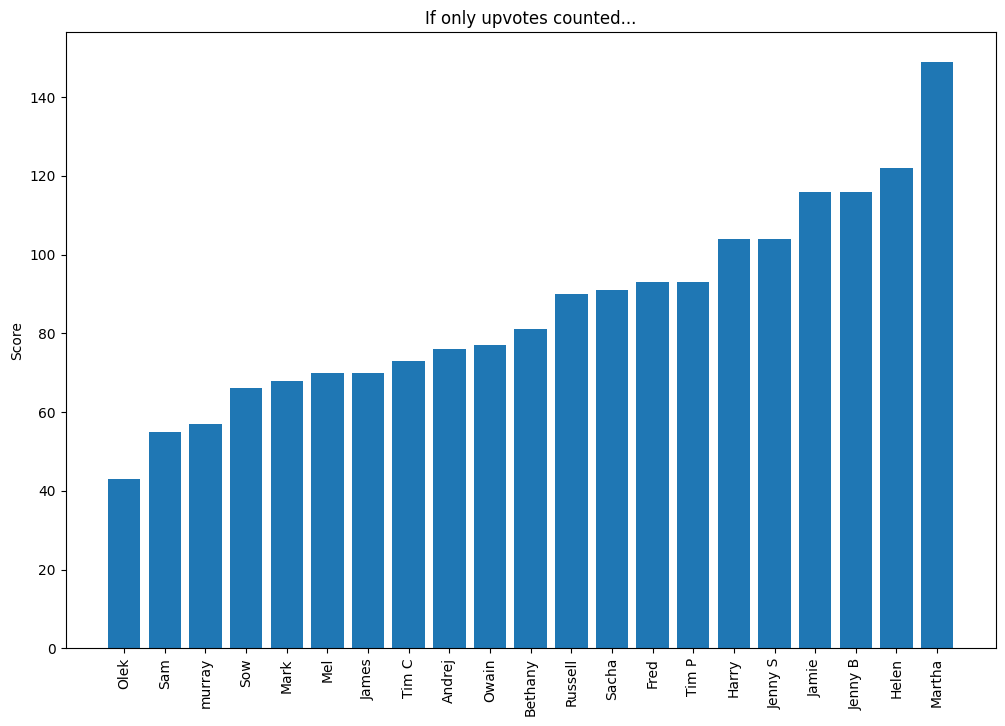

In [142]:
positive_votes = np.where(arr > 0, arr, 0)

positive_scores = np.sum(positive_votes, axis=(0, 2))

order = np.argsort(positive_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(positive_scores))
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only upvotes counted...")

plt.show()

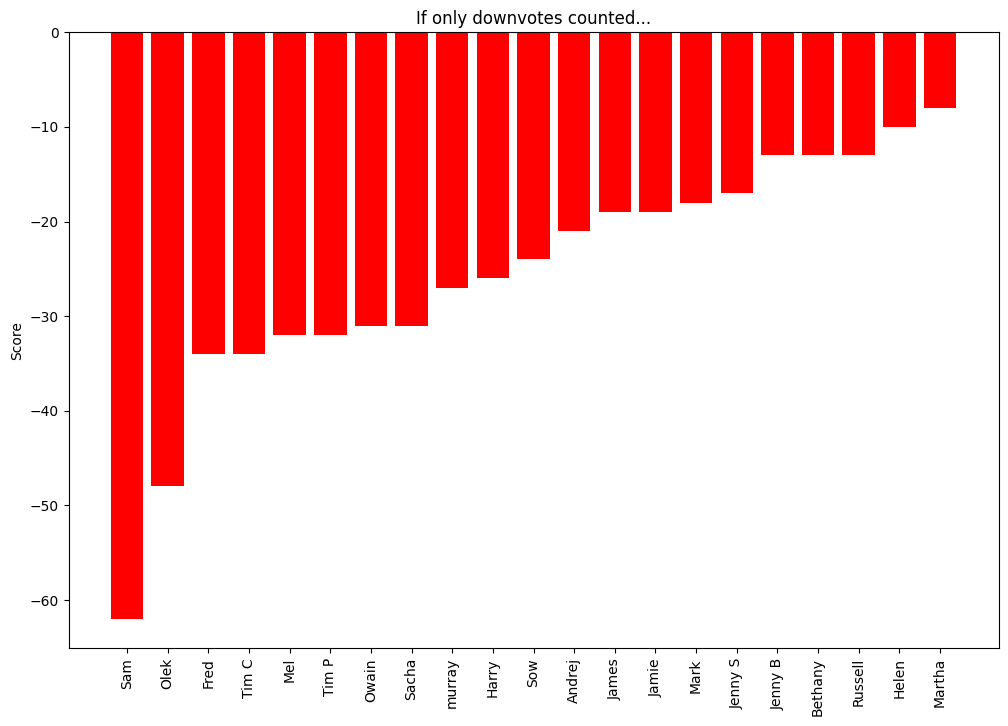

In [143]:
negative_votes = np.where(arr < 0, arr, 0)

negative_scores = np.sum(negative_votes, axis=(0, 2))

order = np.argsort(negative_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(negative_scores), color="red")
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only downvotes counted...")

plt.show()

## Controversy score

The controversy score aims to find the most controversial songs, those with the highest numbers of upvotes and downvotes leaving a score near 0

The controversy score $C$ is calculated using the following formula:


$C = \sqrt{\frac{1}{N_{\neq 0}} \sum_{i=1}^{N_{\neq 0}} (v_i - \mu)^2} \times \left( \sum_{i=1}^{n} v_i \text{ where } v_i > 0 \ - \ \alpha \sum_{i=1}^{n} v_i \text{ where } v_i < 0 \right)$


Where:
- $v_i$ are the individual votes.
- $\mu$ is the mean of the non-zero votes.
- $N_{\neq 0}$ is the number of non-zero votes.
- $\alpha$ is the ratio of positive to negative votes ($\frac{10}{3}$ in this league)
- The first part of the equation represents the standard deviation of the non-zero votes.
- The second part represents a modified range that accounts for positive and scaled negative votes.


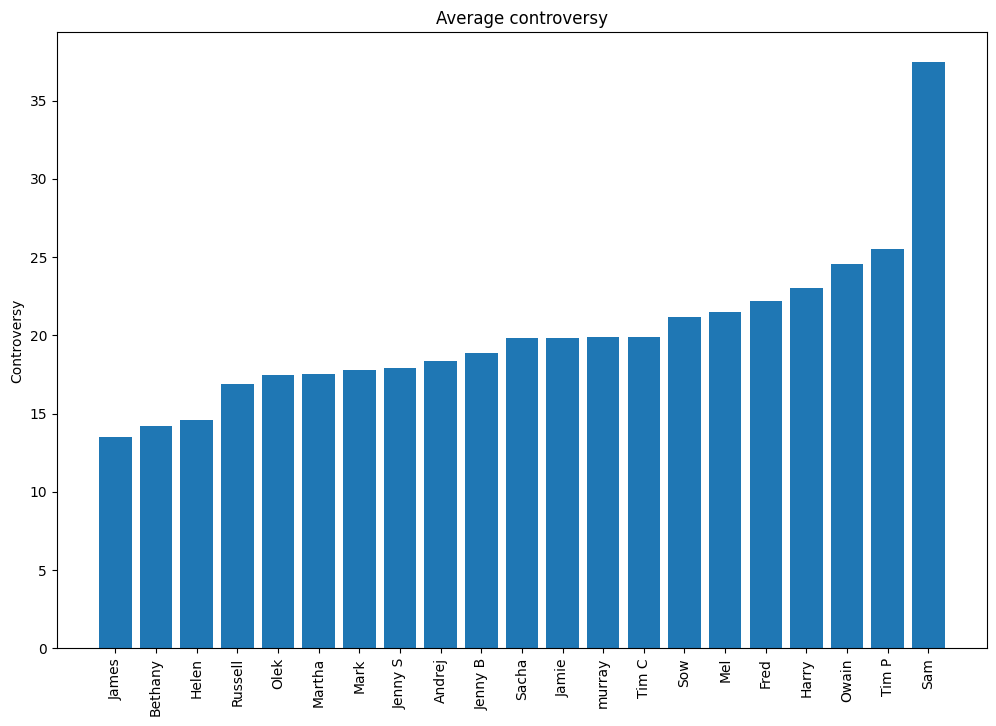

In [144]:
def controversy(vals):
    std = np.std([i for i in vals if i])
    range = sum(i for i in vals if i > 0.0) - (sum(i for i in vals if i < 0.0) * 10/3)
    return std * range

df["controversy"] = df[names].fillna(0).apply(controversy, axis=1)
df.sort_values("controversy", ascending=False)[["submitter", "song_name", "round", "controversy"]].iloc[:10]

fig, ax = plt.subplots(figsize=(12, 8))

vals = df.groupby("submitter")["controversy"].mean().sort_values()

ax.bar(np.arange(len(vals)), vals)
ax.set_xticks(range(len(vals)), vals.index, rotation="vertical")
ax.set_ylabel("Controversy")
ax.set_title("Average controversy")

plt.show()

In [145]:
df.sort_values("controversy", ascending=False)[["controversy", "submitter", "round", "song_name"]].iloc[:10]

,controversy,submitter,round,song_name
140,87.689741,Sam,One hit wonder 🌟,Imagine - Remastered 2010
14,69.565516,Harry,Best live version 🎤,"The Curtain - Live From Dordrecht, Het Energie..."
12,63.356136,Tim P,Best live version 🎤,"Free Fallin' - Live at the Nokia Theatre, Los ..."
71,59.035921,Sacha,Best summer song ☀,My Own Summer (Shove It)
144,56.935134,Jenny B,Riskware's anthem 🎶,The Creativity Song
119,55.217439,Sam,Obscurity 🕵️‍♀️,Fire Alarm
17,55.152386,Owain,Best live version 🎤,Bohemian Rhapsody - Live At Wembley Stadium / ...
162,52.566008,Fred,Riskware's anthem 🎶,Funny Little Man
93,52.056593,Tim P,Boxing entrance music 🥊,Theme from Strictly Come Dancing
95,51.027952,Jamie,Boxing entrance music 🥊,The Greatest Show


In [146]:
print("Number of explicit songs submitted")
df.groupby("submitter")["explicit"].sum().sort_values(ascending=False)

Number of explicit songs submitted


submitter
Mel        6
Sacha      4
murray     3
Jenny B    3
Bethany    3
Tim C      3
Tim P      3
Martha     2
Helen      2
Owain      2
Russell    2
Jamie      2
Andrej     1
Sam        1
Fred       1
James      1
Jenny S    1
Olek       1
Harry      0
Mark       0
Sow        0
Name: explicit, dtype: int64

In [147]:
# Every explicit song
df[df["explicit"]][["submitter", "round", "song_name", "artist_names"]]

,submitter,round,song_name,artist_names
3,Tim C,Best live version 🎤,For Whom The Bell Tolls - Live,[Metallica]
7,Helen,Best live version 🎤,The Passenger - Live,[Iggy Pop]
18,Sacha,Best live version 🎤,Shades of Grey - Live,[Biohazard]
20,Jamie,Best sample 🎛,Stan,"[Eminem, Dido]"
28,Olek,Best sample 🎛,Without Me,[Eminem]
29,Tim P,Best sample 🎛,Pump It,[Black Eyed Peas]
31,Fred,Best sample 🎛,Simon Says,[Pharoahe Monch]
33,Sacha,Best sample 🎛,Serial Killa,"[Snoop Dogg, D.O.C., RBX, Tha Dogg Pound]"
34,Bethany,Best sample 🎛,Gimme Some More,[Busta Rhymes]
36,Russell,Best sample 🎛,Hits from the Bong,[Cypress Hill]
